In [53]:
"""
-*- coding: utf-8 -*-
Created on Fri 21 2020
@author: Thiago Pinho
"""

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import spacy
from spacy.lang.pt import Portuguese
from spacy.lang.pt.stop_words import STOP_WORDS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
VECTOR_MODEL_NAME = "pt_core_news_sm"
RELATIVE_PATH_TO_FOLDER = "./assets/datasets/ribon/"
DATA_FILENAME = "Feeds_Label"
nlp = spacy.load(VECTOR_MODEL_NAME)
TARGET_VARIABLE = "LABEL_TRAIN"
TEXT_VARIABLE = "TITLE"

In [4]:
"""  load the dataset """
relative_path_file = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + ".csv"
df_ribon_news = pd.read_csv(relative_path_file)
print(df_ribon_news.head())

   id  pick_count                                            content  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               title    Label_Train  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        Animais  
1  Muros da gentileza ajudam desabrigados e famíl...  Solidariedade  
2  20 fotos maravilhosas mostrando a alegria de t...        Familia  
3  13 razões pelas quais crianças são bem mais es...       Criancas  
4  Ex-executiva fala sobre vida sem propósito - I...      Proposito  


In [5]:
"""  Preprocess the dataset names and values """
df_ribon_news.columns = map(lambda x: str(x).upper(), df_ribon_news.columns)
df_ribon_news[TARGET_VARIABLE] = df_ribon_news[TARGET_VARIABLE].str.upper()
""" Converting all labels to uppercase """
print(df_ribon_news.head())

   ID  PICK_COUNT                                            CONTENT  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               TITLE    LABEL_TRAIN  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        ANIMAIS  
1  Muros da gentileza ajudam desabrigados e famíl...  SOLIDARIEDADE  
2  20 fotos maravilhosas mostrando a alegria de t...        FAMILIA  
3  13 razões pelas quais crianças são bem mais es...       CRIANCAS  
4  Ex-executiva fala sobre vida sem propósito - I...      PROPOSITO  


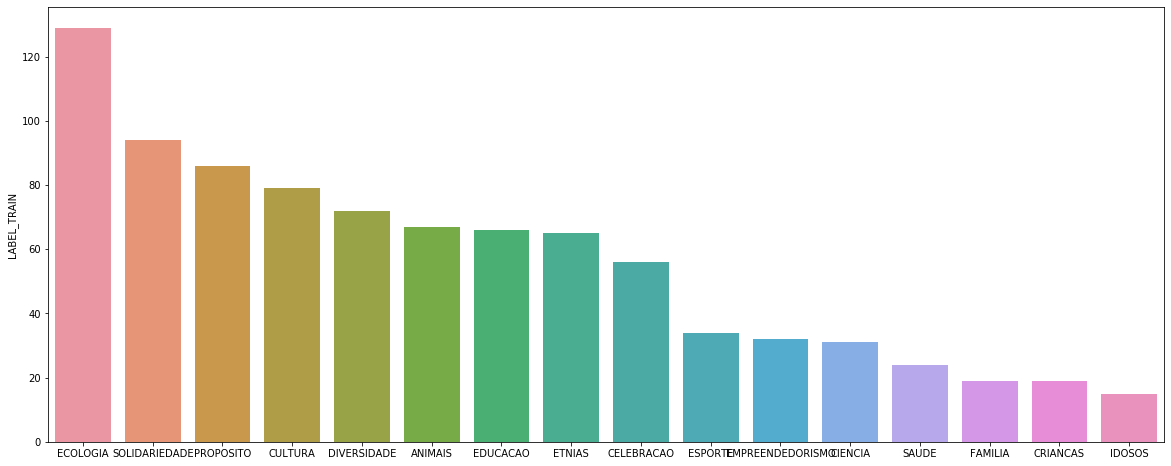

In [5]:
"""  Let"s see how the labels are distributed """
data_labels_count = df_ribon_news[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
fig = plt.figure(figsize=(20, 8))
sns.barplot(
    x=data_labels_count.index,
    y=data_labels_count)
plt.show()


In [6]:

"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME + "_treated.xlsx"

"""  Convert the dataframe to an xlsx file """
df_ribon_news.to_excel(excel_filename)

"""  We then load the data for stability """
df_ribon_news_treated = pd.read_excel(excel_filename, index_col=0)
print(df_ribon_news_treated.head())

   ID  PICK_COUNT                                            CONTENT  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               TITLE    LABEL_TRAIN  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        ANIMAIS  
1  Muros da gentileza ajudam desabrigados e famíl...  SOLIDARIEDADE  
2  20 fotos maravilhosas mostrando a alegria de t...        FAMILIA  
3  13 razões pelas quais crianças são bem mais es...       CRIANCAS  
4  Ex-executiva fala sobre vida sem propósito - I...      PROPOSITO  


In [7]:
data_labels_with_count = df_ribon_news_treated[TARGET_VARIABLE].value_counts()
data_labels = data_labels_with_count.index
for label in tqdm(data_labels):
    print(label + ": ", data_labels_with_count[label])

ECOLOGIA:  129
SOLIDARIEDADE:  94
PROPOSITO:  86
CULTURA:  79
DIVERSIDADE:  72
ANIMAIS:  67
EDUCACAO:  66
ETNIAS:  65
CELEBRACAO:  56
ESPORTE:  34
EMPREENDEDORISMO:  32
CIENCIA:  31
SAUDE:  24
CRIANCAS:  19
FAMILIA:  19
IDOSOS:  15



In [8]:
""" As we have two text variables CONTENT and TITLE.
    we can use both of then to improve predictions
"""
first_pipeline_text_variable = "CONTENT"
second_pipeline_text_variable = "TITLE"

df_first_ribon_news_data = df_ribon_news_treated[
    [first_pipeline_text_variable, TARGET_VARIABLE]]
df_second_ribon_news_data = df_ribon_news_treated[
    [second_pipeline_text_variable, TARGET_VARIABLE]]

"""  Let"s store the data """
excel_first_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_first_data.xlsx"
excel_second_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_second_data.xlsx"

df_first_ribon_news_data.to_excel(excel_first_filename)
df_second_ribon_news_data.to_excel(excel_second_filename)

In [9]:
''' One possible approach is to group up under represented labels and further
    analysis in other pipeline. We analysed the data and found out 
    that some of the labels are under 40 representations which is pretty low.
'''
data_labels_count = df_ribon_news_treated[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
under_represented_labels = [
    scarse_label
    for scarse_label in tqdm(data_labels)
    if data_labels_count[scarse_label] <= 40]
print(under_represented_labels)




['ESPORTE', 'EMPREENDEDORISMO', 'CIENCIA', 'SAUDE', 'CRIANCAS', 'FAMILIA', 'IDOSOS']


In [10]:
''' Now we have found which ones are under represented we'll create a new
    DataFrame changing the under represented to OUTROS '''
GROUP_TARGET_LABEL = 'OUTROS'
df_ribon_news_grouped = df_ribon_news_treated.replace({TARGET_VARIABLE: under_represented_labels}, GROUP_TARGET_LABEL)
print(df_ribon_news_grouped[TARGET_VARIABLE].value_counts())

OUTROS           174
ECOLOGIA         129
SOLIDARIEDADE     94
PROPOSITO         86
CULTURA           79
DIVERSIDADE       72
ANIMAIS           67
EDUCACAO          66
ETNIAS            65
CELEBRACAO        56
Name: LABEL_TRAIN, dtype: int64


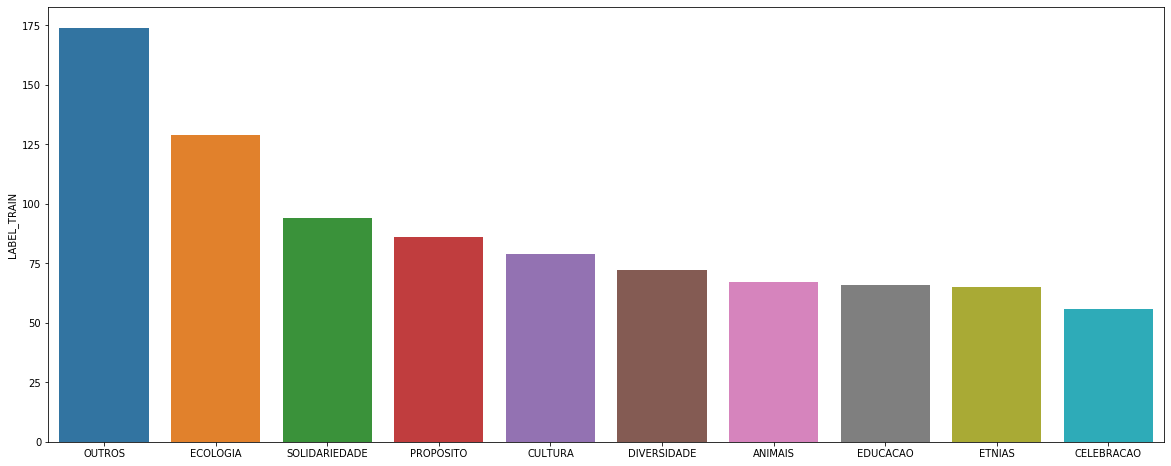

In [12]:
"""  Let"s see how the labels are distributed """
data_labels_count = df_ribon_news_grouped[TARGET_VARIABLE].value_counts()
data_labels = data_labels_count.index
fig = plt.figure(figsize=(20, 8))
sns.barplot(
    x=data_labels_count.index,
    y=data_labels_count)
plt.show()

In [11]:
""" As we have two text variables CONTENT and TITLE.
    we can use both of then to improve predictions
"""
first_pipeline_text_variable = "CONTENT"
second_pipeline_text_variable = "TITLE"

df_first_ribon_news_data_grouped = df_ribon_news_grouped[
    [first_pipeline_text_variable, TARGET_VARIABLE]]
df_second_ribon_news_data_grouped = df_ribon_news_grouped[
    [second_pipeline_text_variable, TARGET_VARIABLE]]


In [13]:
excel_first_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_first_data_grouped.xlsx"
excel_second_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_second_data_grouped.xlsx"

In [14]:
"""  Let"s store the data """
df_first_ribon_news_data_grouped.to_excel(excel_first_filename)
df_second_ribon_news_data_grouped.to_excel(excel_second_filename)

In [15]:
"""  We then load the data for stability """
df_first_data = pd.read_excel(excel_first_filename, index_col=0)
df_second_data = pd.read_excel(excel_second_filename, index_col=0)
print(df_first_data.head())
print(df_second_data.head())

                                             CONTENT    LABEL_TRAIN
0  A forte ligação dos cães com o ser humano desp...        ANIMAIS
1  Os chamados muros da gentileza estão promovend...  SOLIDARIEDADE
2  Alguns de nós sabem a sorte que é ter um irmão...         OUTROS
3               Temos muito o que aprender com elas.         OUTROS
4  Esqueça o que te disseram sobre a zona de conf...      PROPOSITO
                                               TITLE    LABEL_TRAIN
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        ANIMAIS
1  Muros da gentileza ajudam desabrigados e famíl...  SOLIDARIEDADE
2  20 fotos maravilhosas mostrando a alegria de t...         OUTROS
3  13 razões pelas quais crianças são bem mais es...         OUTROS
4  Ex-executiva fala sobre vida sem propósito - I...      PROPOSITO


In [16]:
raw_text_data = df_first_data[first_pipeline_text_variable].to_list()

preprocessed_text_data = [str(raw_text) for raw_text in tqdm(raw_text_data)]
''' Not all variables are being undestood as strings so we have to force it'''

nlp = spacy.load(VECTOR_MODEL_NAME)
''' We an already trained model to process portuguese '''

sentencizer = nlp.create_pipe('sentencizer')
''' Create the pipeline 'sentencizer' component '''

nlp.add_pipe(sentencizer, before='parser')
''' We then add the component to the pipeline '''
print(nlp.pipe_names)

processed_text_data = []
lemmatized_doc = []
for row in tqdm(preprocessed_text_data):
    doc = nlp(row)
    processed_text_data.append(doc)
    lemmatized_doc.append(str([word.lemma_ for word in doc if not word.is_stop]))


['tagger', 'sentencizer', 'parser', 'ner']


In [17]:
df_processed_data = pd.DataFrame()
df_processed_data['PREPROCESSED_TEXT_DATA'] = preprocessed_text_data
df_processed_data['PROCESSED_TEXT_DATA'] = processed_text_data
df_processed_data['LEMMATIZED_DOC'] = lemmatized_doc
df_processed_data[TARGET_VARIABLE] = df_first_data[TARGET_VARIABLE]
print(df_processed_data)

                                PREPROCESSED_TEXT_DATA  \
0    A forte ligação dos cães com o ser humano desp...   
1    Os chamados muros da gentileza estão promovend...   
2    Alguns de nós sabem a sorte que é ter um irmão...   
3                 Temos muito o que aprender com elas.   
4    Esqueça o que te disseram sobre a zona de conf...   
..                                                 ...   
883  Ingrid Silva ficou famosa ao pintar suas sapat...   
884  Apesar de ser a atual campeã mundial de futsal...   
885  Aquele pó de café que sobra no coador e é desc...   
886  Todos os dias, pessoas são forçadas a deixar e...   
887  Naiumy do Reis, 16, tem gênio forte e é cheia ...   

                                   PROCESSED_TEXT_DATA  \
0    (A, forte, ligação, dos, cães, com, o, ser, hu...   
1    (Os, chamados, muros, da, gentileza, estão, pr...   
2    (Alguns, de, nós, sabem, a, sorte, que, é, ter...   
3       (Temos, muito, o, que, aprender, com, elas, .)   
4    (Esqueça

In [18]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + DATA_FILENAME +\
    "_parsed_data.xlsx"

In [19]:
df_processed_data.to_excel(excel_filename)

In [20]:
"""  We then load the data for stability """
df_processed_data = pd.read_excel(excel_filename, index_col=0)
print(df_processed_data.head())

                              PREPROCESSED_TEXT_DATA  \
0  A forte ligação dos cães com o ser humano desp...   
1  Os chamados muros da gentileza estão promovend...   
2  Alguns de nós sabem a sorte que é ter um irmão...   
3               Temos muito o que aprender com elas.   
4  Esqueça o que te disseram sobre a zona de conf...   

                                 PROCESSED_TEXT_DATA  \
0  A forte ligação dos cães com o ser humano desp...   
1  Os chamados muros da gentileza estão promovend...   
2  Alguns de nós sabem a sorte que é ter um irmão...   
3               Temos muito o que aprender com elas.   
4  Esqueça o que te disseram sobre a zona de conf...   

                                      LEMMATIZED_DOC    LABEL_TRAIN  
0  ['A', 'forte', 'ligação', 'cão', 'o', 'humanar...        ANIMAIS  
1  ['chamar', 'muro', 'gentileza', 'promover', 'o...  SOLIDARIEDADE  
2  ['saber', 'o', 'sortir', 'irmão', 'irmão', ','...         OUTROS  
3                             ['o', 'aprender'

In [43]:
''' Best parameter using GridSearch (CV score=0.535):
{'clf__alpha': 1e-05, 'clf__max_iter': 80, 'clf__penalty': 'l2', 'tfidf__norm': 'l1',
'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__ngram_range': (1, 2)}
'''
''' Text Filter
    This part is responsible to give weights to important tokens and remove
    weight for unwanted ones or those who can be misguiding.
    - Frequency Counter
    - Id-IdF Counter
'''
count_vectorizer = CountVectorizer(
    max_features=None, max_df=0.5, ngram_range=(1, 2))
tfidf_transformer = TfidfTransformer(norm='l1', use_idf='True')

''' Let's transform the lemmatized documents into count vectors '''
count_vectors = count_vectorizer.fit_transform(
    df_processed_data['LEMMATIZED_DOC'])

''' Then use those count vectors to generate frequency vectors '''
frequency_vectors = tfidf_transformer.fit_transform(count_vectors)

In [45]:
''' Model Train and Evaluation
'''

clf = SGDClassifier(alpha=1e-05, max_iter=80, penalty='l2')
pipeline_simple = Pipeline([
    ('clf', clf)
])
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer),
    ('clf', clf)
])
''' Let's use cross validation to better evaluate models ''' 
scores = cross_val_score(
    pipeline_simple,
    frequency_vectors,
    df_processed_data[TARGET_VARIABLE], cv=5)
print("Mean accuracy for explicit pipeline: ", scores.mean())

scores = cross_val_score(
    pipeline,
    df_processed_data['LEMMATIZED_DOC'],
    df_processed_data[TARGET_VARIABLE], cv=10)
print("Mean accuracy for implicit pipeline: ", scores.mean())

Mean accuracy for explicit pipeline:  0.49656573351107725
Mean accuracy for implicit pipeline:  0.5370275791624105


In [54]:
''' Let's evaluate more deeply the best model '''
X_train, X_test, y_train, y_test = train_test_split(
    df_processed_data['LEMMATIZED_DOC'],
    df_processed_data[TARGET_VARIABLE],
    test_size=0.33, random_state=42)

train1 = X_train.tolist()
labelsTrain1 = y_train.tolist()
test1 = X_test.tolist()
labelsTest1 = y_test.tolist()
"""  train """
pipeline.fit(train1, labelsTrain1)
"""  test """
preds = pipeline.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print(
    classification_report(
        labelsTest1,
        preds,
        target_names=df_processed_data[TARGET_VARIABLE].unique()))


accuracy: 0.5544217687074829
               precision    recall  f1-score   support

      ANIMAIS       0.82      0.69      0.75        26
SOLIDARIEDADE       0.20      0.05      0.08        20
       OUTROS       0.69      0.60      0.64        30
    PROPOSITO       0.71      0.37      0.49        27
  DIVERSIDADE       0.69      0.80      0.74        41
     EDUCACAO       0.50      0.35      0.41        23
     ECOLOGIA       0.50      0.39      0.44        23
   CELEBRACAO       0.46      0.65      0.54        57
       ETNIAS       0.67      0.54      0.60        26
      CULTURA       0.35      0.71      0.47        21

     accuracy                           0.55       294
    macro avg       0.56      0.52      0.52       294
 weighted avg       0.57      0.55      0.54       294

